### 1. 스택 오토인코더

#### 💡 라이브러리 불러오기

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

----------------------------------------------------------------------------------------------------

#### 💡 GPU 연산 정의 및 MNIST 데이터 불러오기

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = torchvision.datasets.MNIST("./data/", download=False, train=True, transform=transforms.ToTensor())

In [5]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

----------------------------------------------------------------------------------------------------

#### 💡 모델 구축하기

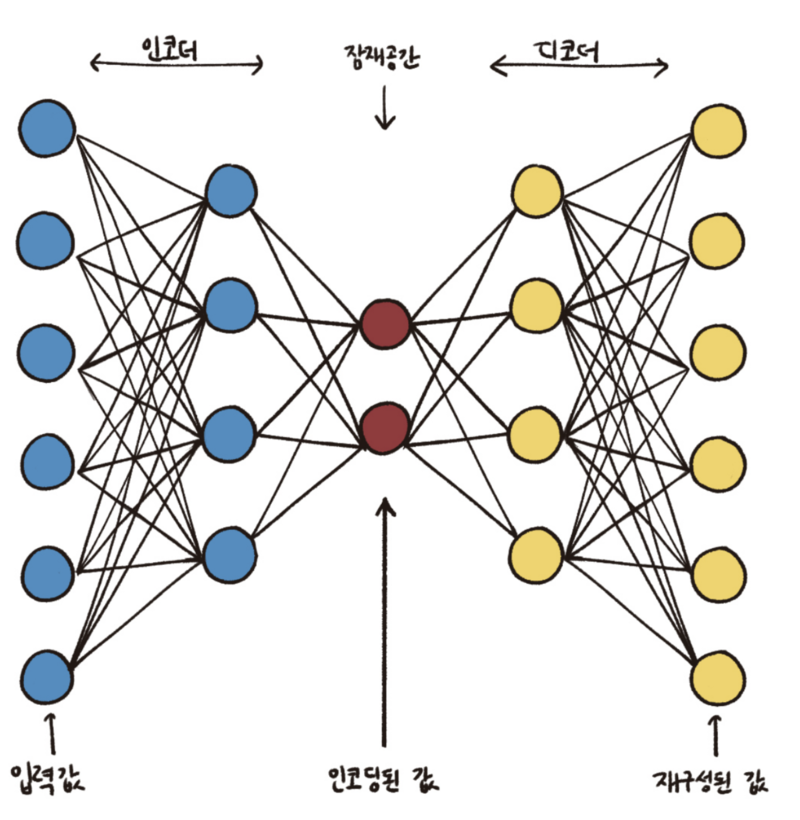

In [29]:
from IPython.display import Image
Image("./picture/autoencoder.png")

- **인코더와 디코더를 각각 `nn.Sequential`로 묶어 보기 좋게 한다.**
-  **`self.encoder`**
    - `nn.Linear(784, 128)`
        - MNIST 이미지의 크기는 1x28x28
        - 따라서 nn.Linear에 넣어주기 위해 사진을 일렬로 편 후, 인코더 부분에 크기가 784(28*28)인 벡터 하나가 들어오게 된다. 
    - 그 후에 여러 층을 자유롭게 쌓아 노드를 10개까지 줄인다. **(즉, 잠재변수의 크기가 10으로 정의)**
    
- **`self.decoder`**
    - 크기가 줄어든 잠재 변수 벡터를 디코더에 넣어 다시 크기를 늘려준다. 
    - 마지막에는 처음과 같은 크기의 이미지가 나와야 하므로 28*28로 입력
    - MNIST 이미지의 픽셀값은 0이상 1이하다. 따라서 nn.Sigmoid()를 이용해 범위를 정해서 수렴을 빨리 하게 한다. 
- **`forward`**
    - 인코더와 디코더를 차례대로 연산

In [11]:
# 모델 클래스 정의 
class Autoencoder(nn.Module) :
    def __init__(self) :
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, 10),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Linear(10, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 28*28),
                                     nn.Sigmoid())
        
        
    def forward(self, x) :
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

----------------------------------------------------------------------------------------------------

#### 💡 모델, 손실함수, 최적화 기법 정의하기

- **입력 이미지와 유사한 출력 이미지를 얻는 것**
- 따라서 입력 이미지와 출력 이미지의 `L2 Distance`를 계산하는 `MSE Loss function`를 사용
- 최적화 방법은 `Adam`

In [12]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

----------------------------------------------------------------------------------------------------

#### 💡 학습하기

- **`First outputs`**
    - 현재 오토인코더의 층은 합성곱 층이 아니고 일렬 노드로 구성된 nn.Linear
    - 따라서 이미지를 일렬로 펴서 넣어주기 위해 `inputs.view(-1, 28*28)`
- **`Second outputs`**
    - 벡터 형태로 나온 출력값을 다시 정사각형 이미지로 변환하기 위해 `outputs.view(-1, 1, 28, 28)`

In [25]:
for epoch in range(5) :
    running_loss = 0
    for data in trainloader :
        # data[0] : torch.Size([50, 1, 28, 28])
        inputs = data[0].to(device)
        optimizer.zero_grad()
        
        # torch.Size([50, 784])
        outputs = model(inputs.view(-1, 28*28))
        
        # torch.Size([50, 1, 28, 28])
        outputs = outputs.view(-1, 1, 28, 28)
        
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost = running_loss / len(trainloader)
    print("[%d] loss: %.3f" % (epoch + 1, cost))

[1] loss: 0.039
[2] loss: 0.036
[3] loss: 0.034
[4] loss: 0.033
[5] loss: 0.032


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

### 2. 디노이징 오토인코더

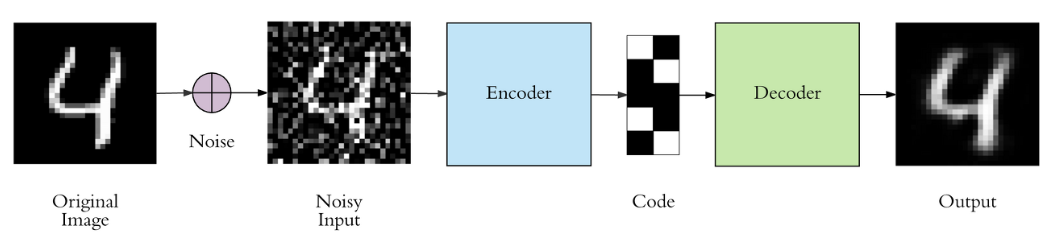

In [31]:
from IPython.display import Image
Image("./picture/dae.PNG")

#### 💡 학습하기

- **`dirty_inputs`**
    - 스택 오토인코더와 동일한 코드에다가 입력 이미지에 가우시안 노이즈 주입 !
    - 노이즈 텐서의 사이즈는 이미지 사이즈와 같아야 한다. 
    - 평균과 표준편차는 임의로 0, 0.5
    - `+ torch.normal(0, 0.5, size=inputs.size())`
- **`outputs`**
    - 출력은 마찬가지로 사각형 이미지여야 하므로 `outputs.view(-1, 1, 28, 28)`

In [32]:
for epoch in range(101) :
    
    running_loss = 0.0
    for data in trainloader :
        inputs = data[0].to(device)
        optimizer.zero_grad()
        dirty_inputs = inputs + torch.normal(0, 0.5, size=inputs.size()).to(device)
        outputs = model(dirty_inputs.view(-1, 28*28))
        outputs = outputs.view(-1, 1, 28, 28)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost = running_loss/len(trainloader)
    print("[%d] loss: %.3f" % (epoch+1, cost))

[1] loss: 0.035
[2] loss: 0.034
[3] loss: 0.034
[4] loss: 0.033
[5] loss: 0.033
[6] loss: 0.033
[7] loss: 0.032
[8] loss: 0.032
[9] loss: 0.032
[10] loss: 0.032
[11] loss: 0.031
[12] loss: 0.031
[13] loss: 0.031
[14] loss: 0.031
[15] loss: 0.031
[16] loss: 0.031
[17] loss: 0.031
[18] loss: 0.030
[19] loss: 0.030
[20] loss: 0.030
[21] loss: 0.030
[22] loss: 0.030
[23] loss: 0.030
[24] loss: 0.030
[25] loss: 0.030
[26] loss: 0.030
[27] loss: 0.030
[28] loss: 0.030
[29] loss: 0.030
[30] loss: 0.029
[31] loss: 0.029
[32] loss: 0.029
[33] loss: 0.029
[34] loss: 0.029
[35] loss: 0.029
[36] loss: 0.029
[37] loss: 0.029
[38] loss: 0.029
[39] loss: 0.029
[40] loss: 0.029
[41] loss: 0.029
[42] loss: 0.029
[43] loss: 0.029
[44] loss: 0.029
[45] loss: 0.029
[46] loss: 0.029
[47] loss: 0.028
[48] loss: 0.028
[49] loss: 0.028
[50] loss: 0.028
[51] loss: 0.028
[52] loss: 0.028
[53] loss: 0.028
[54] loss: 0.028
[55] loss: 0.028
[56] loss: 0.028
[57] loss: 0.028
[58] loss: 0.028
[59] loss: 0.028
[60] l

KeyboardInterrupt: 

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

### 3. 합성곱 오토인코더

#### 💡 피쳐맵을 벡터화하기

- 인코더를 거친 Feature map의 크기 : (배치 사이즈, 채널 수, 이미지 너비, 이미지 높이)
- 배치 사이즈가 현재 이미지의 개수이므로 벡터가 배치 사이즈 만큼 존재해야 한다. 
- 즉, `x.view(batch_size, -1)`를 이용해서 각 피쳐 데이터를 일렬로 변환

In [33]:
class Flatten(torch.nn.Module) :
    def forward(self, x) :
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

----------------------------------------------------------------------------------------------------

#### 💡 벡터를 사각형 피쳐맵으로 변환하기

- **`feature_size`**
    - 잠재변수 h의 크기는 (배치사이즈, 채널수*이미지 너비*이미지 높이)
    - 따라서 벡터 사이즈는 채널수*이미지 너비*이미지 높이이고, 너비와 높이가 같다면 채널수*이미지 너비*2
    - 이미지 한변의 길이는 (벡터사이즈//채널수)**.5
- **`return`**
    - 피쳐맵의 크기를 (배치사이즈, 채널수, 이미지 너비, 이미지 높이) = (s[0], self.k, feature_size, feature_size)로 반환

In [34]:
class Deflatten(nn.Module) :
    def __init__(self, k) :
        super(Deflatten, self).__init__()
        self.k = k
        
    def forward(self, x) :
        s = x.size()
        feature_size = int((s[1]//self.k) ** .5)
        return x.view(s[0], self.k, feature_size, feature_size)

----------------------------------------------------------------------------------------------------

#### 💡 모델 구축하기

- **`self.encoder`**
    - 합성곱 층을 만든다.
    - `Flatten(), nn.Linear(), nn.ReLU()`
        - 합성곱 층으로부터 나온 피쳐맵을 일렬로 편다. 
        - 피쳐맵으로 만든 벡터를 은닉층 하나를 거쳐 크기가 10인 잠재 변수를 만든다.
        
- **`self.decoder`**
    - `nn.Linear` : 잠재 변수를 은닉층 하나를 통해 다시 크기가 1024인 벡터로 만든다. 
    - `Deflatten` : 사각형 형태의 피쳐맵으로 변환한다. (nn.Conv2d는 일반적으로 입력 사이즈보다 출력 사이즈가 더 작다.)
    - `nn.ConvTranspose2d`
        - 크기가 작은 입력값을 크기가 큰 입력값으로 만들기 위해 사용
        - 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출하고, 그 결과 벡터를 행렬 형태로 변환하는 연산
        - (입력 채널 수, 출력 채널 수, 필터 크기, stride)로 입력
        - 크기는 일반적인 정사각형 이미지와 필터를 사용했을 경우 다음 식에 의해 피쳐맵의 크기 산출
        - ⚠ **(출력값의 크기) = (입력값의 크기 - 1)x(보폭) - 2x(패딩) + (필터의 크기) + (출력값 패딩)** ⚠ 
        - output_padding은 크기를 맞춰주기 위해 전치 합성곱 연산을 한 후 패딩을 씌워주는 역할
    

In [35]:
class Autoencoder(nn.Module) :
    def __init__(self) :
        super(Autoencoder, self).__init__()
        k = 16
        self.encoder = nn.Sequential(nn.Conv2d(1, k, 3, stride=2), nn.ReLU(),
                                     nn.Conv2d(k, 2*k, 3, stride=2), nn.ReLU(),
                                     nn.Conv2d(2*k, 4*k, 3, stride=1), nn.ReLU(),
                                     Flatten(), nn.Linear(1024, 10), nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Linear(10, 1024), nn.ReLU(),
                                     Deflatten(4*k),
                                     nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), nn.ReLU(),
                                     nn.ConvTranspose2d(2*k, k, 3, stride=2), nn.ReLU(),
                                     nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), nn.Sigmoid())
        
    def forward(self, x) :
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

----------------------------------------------------------------------------------------------------

#### 💡 모델, 손실함수, 최적화 기법 정의하기

In [37]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

----------------------------------------------------------------------------------------------------

#### 💡 학습하기

- 오코인코더와 학습 과정은 동일
- 차이점은 이미지를 그대로 받아서 학습하기 때문에 별도의 크기 변환이 필요 없다.
- 합성곱 오토인코더는 이미지 처리에서는 기본 신경망을 사용하는 오토인코더보다 성능이 뛰어나다. 

In [38]:
for epoch in range(5) :
    running_loss = 0.0
    for data in trainloader :
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    cost = running_loss / len(trainloader)
    if epoch % 10 == 0 :
        print("[%d] loss: %.3f" % (epoch+1, cost))

[1] loss: 0.099
